In [1]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import numpy as np
import openpyxl
from openpyxl import load_workbook
from openpyxl.styles import Font, Alignment
import warnings
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, precision_recall_curve, confusion_matrix
import pylab as pl
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


# ---Modeling the data---

## 3. What are the most important features to determine the outcome of a round? Does it differ between 2v2 and 3v3?

### Logistic regression is chosen because Round_Won is a binary variable with 0 (loss or draw) or 1 (win).

### The model building strategy outlined in Chapter 4 of this book is used https://github.com/Drxan/Study/blob/master/Books_Need2Read/David%20W.%20Hosmer%20-%20Applied%20Logistic%20Regression%20-%203rd%20Edition.pdf

### Only steps 1-6 are used because I'm concerned mostly with measuring the effects and not about inference. This is also why I'm not using a train-test split, though the book recommends using all data to fit the model regardless.

### Also note that I tried to fit a variety of different set of predictors from the data other than the two sets columns listed at the end of the last notebook. There were a lot of issues with models not converging, random error messages, extremely long 100+ hours runtime, etc.

### The two set of columns used for each 2v2/3v3 model was a result of this long testing process.

In [2]:
####################
###MODEL BUILDING###
####################

#Confusion matrix plot function
def plot_confusion_matrix(y_true, y_pred, filename,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`. Taken from 
    https://www.kaggle.com/chrised209/support-vector-machine-modeling-of-iris-dataset
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [0, 1]
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig(filename, bbox_inches="tight")
    return ax



#Adapted for logistic regression
def slr(response, variable, category, reference = False):
    '''
    Converts categorical to dummies before attempting to fit a simple logistic regression model. A reference group is specified.
    For continuous variables, no dummy variable conversion or reference group is specified.
    '''
    if category == True:
        X = pd.get_dummies(df[variable])
        X = sm.add_constant(X)
        del X[reference]
        y = df[response]
        model = sm.Logit(y, X).fit(disp = False, method = 'powell')
        return model
    else:
        X = df[variable]
        X = sm.add_constant(X)
        y = df[response]
        model = sm.Logit(y, X).fit(disp = False, method = 'powell')
        return model
    
def univariate_reg(df, response, alpha):
    '''
    Automatically fit all predictors to the response and determine which variables are significant and not signicant at the
    univariate level.
    '''
    sig = []
    sigpvalue = []
    notsig = []
    notsigpvalue = []
    
    for variable in df.columns:
        #Skip response variable
        if variable == response:
            continue
        
        #Check if category variable
        if type(df[variable][0]) == str:
            
            categories = df[variable].value_counts().reset_index()
            
            if not ((len(categories) == 2) and (categories.loc[0, 'index'] in ['0', '1']) and \
                   (categories.loc[1, 'index'] in ['0', '1'])):
                
                #Use most populated category as reference group if not 1/0 indicator format already
                reference = categories.loc[0, 'index']
                model = slr(response, variable, True, reference)
                
            else:
                
                df[variable] = df[variable].astype(int)
                model = slr(response, variable, False)
                
            #Significant if less than alpha
            if model.llr_pvalue < alpha:
                sig.append(variable)
                sigpvalue.append(model.llr_pvalue)
            else:
                notsig.append(variable)
                notsigpvalue.append(model.llr_pvalue)
                
        else:
            
            model = slr(response, variable, False)
            
            if model.llr_pvalue < alpha:
                sig.append(variable)
                sigpvalue.append(model.llr_pvalue)
            else:
                notsig.append(variable)
                notsigpvalue.append(model.llr_pvalue)
                
    Sig_df = pd.DataFrame(list(zip(sig, sigpvalue)), columns = ['Variable', 'p-value'])
    Notsig_df = pd.DataFrame(list(zip(notsig, notsigpvalue)), columns = ['Variable', 'p-value'])
    
    return(Sig_df, Notsig_df)




def build_model(df, response, univariate_alpha, alpha, exclusions, filename):
    '''
    Adapts the model building strategy steps 1-6 outlined in chapter 4 in the book:
    https://github.com/Drxan/Study/blob/master/Books_Need2Read/David%20W.%20Hosmer%20-%20Applied%20Logistic%20Regression%20-%203rd%20Edition.pdf
    
    '''
    
    #Stop fail messages
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
    
        #Univariate analysis
        print('Step 1')
        sig, notsig = univariate_reg(df, response, univariate_alpha)
        
        ###########################
        ###Build model steps 2-3###
        ###########################
        
        print('Step 2, 3')
        
        variables = []
        references = []
        other_groups = []
    
        #Include only significant variables
        df2 = df.drop(notsig['Variable'].values, axis = 1)
        
        #Get data to right shape
        for variable in sig['Variable']:
            selected_column = df2.loc[:, variable]
            variables.append(variable)
            
            #Check if selected column is a category variable non indicator
            if type(selected_column[0]) == str:
    
                categories = selected_column.value_counts().reset_index()
                    
                #Use most populated category as reference group if not 1/0 indicator format already
                reference = categories.loc[0, 'index']
    
                #Find left over levels of category variable
                other_groups.append(' | '.join(list(df[variable].value_counts().reset_index().drop(0, axis = 0)['index'].values)))
    
                dummies = pd.get_dummies(selected_column)
    
                #Delete old var and concat dummies to data. Delete reference group
                df2 = df2.drop([variable], axis = 1)
                df2 = pd.concat([df2, dummies], axis = 1)
                df2 = df2.drop([reference], axis = 1)
      
                references.append(reference)
                
            #Continuous variable and indicator variables   
            else:
                
                #Check if indicator category variable
                categories = selected_column.value_counts().reset_index()
                
                if ((len(categories) == 2) and (categories.loc[0, 'index'] in [0, 1]) and \
                    (categories.loc[1, 'index'] in [0, 1])):
                    
                    other_groups.append('1')
                    references.append('0')
                      
                else:
                
                    references.append('N/A')
                    other_groups.append('N/A')
                
        #Build reference table
        ref_table = pd.DataFrame(list(zip(variables, references, other_groups)), 
                                 columns = ['Variable', 'Reference Group', 'Levels'])
    
        #Build initial model with all significant univariate variables
        X = df2.drop([response], axis = 1)
        X = sm.add_constant(X)
        y = df2[response]
        full_model = sm.Logit(y, X).fit(disp = False, method = 'powell')
    
    
    
        full_model_log_likelihood = full_model.llf
        full_model_params = full_model.params.reset_index()
        full_model_params.columns = ['Parameter', 'Full_Model_Beta']
        
        conclusion = []
        note = []
        
        #Try removing one variable at a time to see if model can be reduced
        for index, row in ref_table.iterrows():
            
            #Remove variable
            #Indicator or continuous variables
            if ((row['Reference Group'] == 0 and row['Levels'] == 1) or row['Reference Group'] == 'N/A'):
                X2 = X.drop(row['Variable'], axis = 1)
                
            else:
                
                #If coded 0/1 already, use Variable name to drop
                if row['Reference Group'] == '0':
                    X2 = X.drop(row['Variable'], axis = 1)
    
                else:
    
                    X2 = X.drop(row['Levels'].split(' | '), axis = 1)
                
            #Fit reduced model
            reduced_model = sm.Logit(y, X2).fit(disp = False, method = 'powell')
            reduced_model_log_likelihood = reduced_model.llf
            
            #Partial log likelihood test
            partial_llr = -2*(reduced_model_log_likelihood - full_model_log_likelihood)
            df_llr = full_model.df_model - reduced_model.df_model
            p_val_llr = 1 - stats.chi2.cdf(partial_llr, df_llr)
            
            #If below alpha, keep full model
            if p_val_llr < alpha:
                conclusion.append('Full Model')
                note.append('p value < alpha')
                continue
            
            #Else, keep reduced model
            else:
                #Second check for beta coefficients. Use full model if any coefficient changed more than 20% compared to full model
                reduced_model_params = reduced_model.params.reset_index()
                reduced_model_params.columns = ['Parameter', 'Reduced_Model_Beta']
                
                params_comparison = pd.merge(reduced_model_params, full_model_params, on = 'Parameter', how = 'inner')
                params_comparison['Percent_Change'] = (params_comparison['Reduced_Model_Beta'] - params_comparison['Full_Model_Beta'])*100/params_comparison['Full_Model_Beta']
                
                full = False
                #Check if any > 20%
                for change in params_comparison['Percent_Change']:
                    if change > 20:
                        #Keep full model
                        conclusion.append('Full Model')
                        note.append('p value > alpha but one or more beta percent change was greater than 20%')
                        full = True
                        break
                        
                if full:
                    continue
                
                #Pass check, means stick to reduced model, recompute what is full model
                conclusion.append('Reduced Model')
                note.append('p value > alpha and beta changes all less than 20%')
                X = X2.copy()
                full_model = sm.Logit(y, X).fit(disp = False, method = 'powell')
                full_model_log_likelihood = full_model.llf
                full_model_params = full_model.params.reset_index()
                full_model_params.columns = ['Parameter', 'Full_Model_Beta']
                
        #Build second reference_table for model building conclusions
        ref_table2 = ref_table.copy()
        ref_table2['Conclusion'] = conclusion
        ref_table2['Note'] = note
        
        
    
        ###########################
        ###MODEL BUILDING STEP 4###
        ###########################
        
        print('Step 4')
        
        #Add each variable found not significant at univariate analysis stage to see if significant now
        conclusion = []
        note = []
        variables = []
        references = []
        other_groups = []
        
        #Build reference table for conclusion reduced or full model and levels/reference group
        #Include only non significant variables
        df3 = df.drop(sig['Variable'].values, axis = 1)
        
        #Get data to right shape
        for variable in notsig['Variable']:
            selected_column = df3.loc[:, variable]
            variables.append(variable)
            
            #Check if selected column is a category variable non indicator
            if type(selected_column[0]) == str:
    
                categories = selected_column.value_counts().reset_index()
                    
                #Use most populated category as reference group if not 1/0 indicator format already
                reference = categories.loc[0, 'index']
    
                #Find left over levels of category variable
                other_groups.append(' | '.join(list(df[variable].value_counts().reset_index().drop(0, axis = 0)['index'].values)))
    
                dummies = pd.get_dummies(selected_column)
    
                #Delete old var and concat dummies to data. Delete reference group
                df3 = df3.drop([variable], axis = 1)
                df3 = pd.concat([df3, dummies], axis = 1)
                df3 = df3.drop([reference], axis = 1)
      
                references.append(reference)
                
            #Continuous variable and indicator variables   
            else:
                
                #Check if indicator category variable
                categories = selected_column.value_counts().reset_index()
                
                if ((len(categories) == 2) and (categories.loc[0, 'index'] in [0, 1]) and \
                    (categories.loc[1, 'index'] in [0, 1])):
                    
                    other_groups.append('1')
                    references.append('0')
                    
                    
                else:
                
                    references.append('N/A')
                    other_groups.append('N/A')
                
        #Build reference table
        ref_table = pd.DataFrame(list(zip(variables, references, other_groups)), 
                                 columns = ['Variable', 'Reference Group', 'Levels'])
        
        #Previous full model now the reduced model, set variables
        reduced_model = sm.Logit(y, X).fit(disp = False, method = 'powell')
        reduced_model_log_likelihood = reduced_model.llf
        
        #Add to previous model by concat neccessary columns for new variable depend on number of categories
        for index, row in ref_table.iterrows():
    
            #Continuous variables and indicator variables
            if ((row['Reference Group'] == '0' and row['Levels'] == '1') or row['Reference Group'] == 'N/A'):
                X2 = pd.concat([X, df3.loc[:, row['Variable']]], axis = 1)
            
            else:
                X2 = pd.concat([X, df3.loc[:, row['Levels'].split(' | ')]], axis = 1)
            
            #Fit full model
            error = False
            try:
                full_model = sm.Logit(y, X2).fit(disp = False, method = 'powell')
            except:
                error = True
                
            if not error:
                full_model_log_likelihood = full_model.llf
                
                #Partial log likelihood test
                partial_llr = -2*(reduced_model_log_likelihood - full_model_log_likelihood)
                df_llr = full_model.df_model - reduced_model.df_model
                p_val_llr = 1 - stats.chi2.cdf(partial_llr, df_llr)
                
                #If below alpha, keep full model
                if p_val_llr < alpha:
                    conclusion.append('Full Model')
                    note.append('p value < alpha')
                    
                    X = X2.copy()
                    reduced_model = sm.Logit(y, X).fit(disp = False, method = 'powell')
                    reduced_model_log_likelihood = reduced_model.llf
                    
                else:
                    conclusion.append('Reduced Model')
                    note.append('p value > alpha')
            else:
                conclusion.append('Reduced Model')
                note.append('Singular Matrix')
                            
        #Build third reference_table for model building conclusions
        ref_table3 = ref_table.copy()
        ref_table3['Conclusion'] = conclusion
        ref_table3['Note'] = note
        
        #Another reference table indicating which variables are in the current model
        ref_table4a = ref_table2.copy()
        ref_table4b = ref_table3.copy()
        
        indexes_to_delete = []
        
        for index, row in ref_table4a.iterrows():
            if row['Conclusion'] == 'Reduced Model':
                indexes_to_delete.append(index)
        
        ref_table4a = ref_table4a.drop(indexes_to_delete, axis = 0).reset_index(drop = True)
        
        indexes_to_delete = []
        
        for index, row in ref_table4b.iterrows():
            if row['Conclusion'] == 'Reduced Model':
                indexes_to_delete.append(index)
                
        ref_table4b = ref_table4b.drop(indexes_to_delete, axis = 0).reset_index(drop = True)
        
        if len(ref_table4b) > 0:
            
            ref_table4a = pd.concat([ref_table4a, ref_table4b], axis = 0).reset_index(drop = True)
            
        ref_table4 = ref_table4a.copy().drop(['Conclusion', 'Note'], axis = 1)
        
        ############################
        ###FRACTIONAL POLYNOMIALS###
        ############################
        
        print('Step 5')
        
        #Copy of ref table 4
        ref_table5 = ref_table4.copy()
        
        to_delete = []
        #Filter out categorical variables
        for index, row in ref_table5.iterrows():
            if row['Reference Group'] != 'N/A':
                to_delete.append(index)
                
        ref_table5 = ref_table5.drop(to_delete, axis = 0).reset_index(drop = True)
        
        #Initialize results table variables
        table_var = []
        order = ['Linear', 'First Order', 'Second Order']*len(ref_table5)
        DF = [1, 2, 4]*len(ref_table5)
        table_ll = []
        table_pval = []
        powers = []
        
        #Initialize summary table variables
        original_variables = []
        new_variables = []
        final_x = X.copy()
        
        for index, row in ref_table5.iterrows():
    
            variable = row['Variable']
            
             #Copy of initial variables
            initial_x = final_x.copy()
            
            #Log likelihood initial model
            reduced_log_likelihood = reduced_model.llf
            
            #Append values to table variables
            table_var.append(variable)
            table_var.append(variable)
            table_var.append(variable)
            
            table_ll.append(str(round(reduced_log_likelihood, 4)))
            table_pval.append('N/A')
            powers.append('1')
            
            #Append values to summary variable
            original_variables.append(variable)
            
            ########################################
            ###First order fractional polynomials###
            ########################################
            
            ####
            #-2#
            ####
            
            #Transformation
            def transform_power_neg_2(x):
                if x == 0:
                    return 0
                else:
                    return(1/(x**2))
                    
            initial_x[variable+'_-2'] = initial_x[variable].apply(transform_power_neg_2)
        
            #Drop linear term
            x2 = initial_x.drop(variable, axis = 1)
            
    
            #Fit model
            transformed_model = sm.Logit(y, x2).fit(disp = False, method = 'powell')
            #Only proceed if model converged
            if transformed_model.mle_retvals['converged']:
                #Set as best log likelihood for now
                best_log_likelihood = transformed_model.llf
                best_x = x2.copy()
                best_model = transformed_model
                
            else:
                best_log_likelihood = reduced_log_likelihood
    
            
            ####
            #-1#
            ####
            
            #Copy of initial variables
            initial_x = final_x.copy()
            
            def transform_power_neg_1(x):
                if x == 0:
                    return 0
                else:
                    return(1/x)
         
            #Transformation
            initial_x[variable+'_-1'] = initial_x[variable].apply(transform_power_neg_1)
      
            #Drop linear term
            x2 = initial_x.drop(variable, axis = 1)
    
            #Fit model
            transformed_model = sm.Logit(y, x2).fit(disp = False, method = 'powell')
            
            #Only proceed if model converged
            if transformed_model.mle_retvals['converged']:
                #Compare to best log likelihood
                if transformed_model.llf > best_log_likelihood:
                    best_log_likelihood = transformed_model.llf
                    best_x = x2.copy()
                    best_model = transformed_model
    
                    
            ###### 
            #-0.5# 
            ######
            
            #Copy of initial variables
            initial_x = final_x.copy()
            
            #Transformation
            def transform_neg_sqrt(x):
                if x == 0:
                    return 0
                else:
                    return(1/(np.sqrt(x)))
                    
            initial_x[variable+'_-0.5'] = initial_x[variable].apply(transform_neg_sqrt)
            
            #Don't fit negative values
            if initial_x[variable].min() > 0:
            
            #Drop linear term
                x2 = initial_x.drop(variable, axis = 1)
                
                #Fit model
                transformed_model = sm.Logit(y, x2).fit(disp = False, method = 'powell')
                
                #Only proceed if model converged
                if transformed_model.mle_retvals['converged']:
                    #Compare to best log likelihood
                    if transformed_model.llf > best_log_likelihood:
                        best_log_likelihood = transformed_model.llf
                        best_x = x2.copy()
                        best_model = transformed_model    
            
            ###
            #0#
            ###   
            
            #Copy of initial variables
            initial_x = final_x.copy()
            
            #Transformation
            initial_x[variable+'_0'] = np.log(initial_x[variable])
            
            #Drop linear term
            x2 = initial_x.drop(variable, axis = 1)
            
            #Don't fit negative values
            if initial_x[variable].min() > 0:
            
                #Fit model
                transformed_model = sm.Logit(y, x2).fit(disp = False, method = 'powell')
                
                #Only proceed if model converged
                if transformed_model.mle_retvals['converged']:
                    #Compare to best log likelihood
                    if transformed_model.llf > best_log_likelihood:
                        best_log_likelihood = transformed_model.llf
                        best_x = x2.copy()
                        best_model = transformed_model
            
            #####
            #0.5#
            #####
        
            #Copy of initial variables
            initial_x = final_x.copy()
         
            #Transformation
            initial_x[variable+'_0.5'] = np.sqrt(initial_x[variable])
            
            #Don't fit negative values
            if initial_x[variable].min() > 0:
            
                #Drop linear term
                x2 = initial_x.drop(variable, axis = 1)
                
                #Fit model
                transformed_model = sm.Logit(y, x2).fit(disp = False, method = 'powell')
                
                #Only proceed if model converged
                if transformed_model.mle_retvals['converged']:
                    #Compare to best log likelihood
                    if transformed_model.llf > best_log_likelihood:
                        best_log_likelihood = transformed_model.llf
                        best_x = x2.copy()
                        best_model = transformed_model        
            
            ###
            #2#
            ###
            
            #Copy of initial variables
            initial_x = final_x.copy()
         
            #Transformation
            initial_x[variable+'_2'] = initial_x[variable]**2
            
            #Drop linear term
            x2 = initial_x.drop(variable, axis = 1)
            
      
            #Fit model
            transformed_model = sm.Logit(y, x2).fit(disp = False, method = 'powell')
            
            #Only proceed if model converged
            if transformed_model.mle_retvals['converged']:
                #Compare to best log likelihood
                if transformed_model.llf > best_log_likelihood:
                    best_log_likelihood = transformed_model.llf
                    best_x = x2.copy()
                    best_model = transformed_model   
    
            
            ### 
            #3#
            ###
        
            #Copy of initial variables
            initial_x = final_x.copy()
         
            #Transformation
            initial_x[variable+'_3'] = initial_x[variable]**3
            
            #Drop linear term
            x2 = initial_x.drop(variable, axis = 1)
            
            #Fit model
            transformed_model = sm.Logit(y, x2).fit(disp = False, method = 'powell')
            
            #Only proceed if model converged
            if transformed_model.mle_retvals['converged']:
                #Compare to best log likelihood
                if transformed_model.llf > best_log_likelihood:
                    best_log_likelihood = transformed_model.llf
                    best_x = x2.copy()
                    best_model = transformed_model   
            
            ##########################################################
            ###Compare best 1st order term log likelihood to linear###
            ##########################################################
            
            #Partial log likelihood test
            partial_llr = -2*(reduced_log_likelihood - best_log_likelihood)
            p_val_llr = 1 - stats.chi2.cdf(partial_llr, 1)
            
            if p_val_llr < alpha:
                first_order = True
                
                #Summary table stuff
                transformed_variables = best_x.columns[-1]
            else:
                first_order = False
                
                #Summary table stuff
                transformed_variables = 'N/A'
                
            
            linear_best_log_likelihood = best_log_likelihood
            try:
                linear_best_x = best_x
                linear_best_model = best_model
            except:
                linear_best_x = final_x.copy()
                linear_best_model = reduced_model
            
            #Add results to results table
            round_pval = round(p_val_llr, 4)
            if round_pval < 0.0001:
                table_pval.append('<0.0001')
            else:
                table_pval.append(str(round_pval))
                
            table_ll.append(str(round(linear_best_log_likelihood, 4)))
            
            last_col = linear_best_x.columns[-1]
            power = last_col[(len(variable)+1):]
            powers.append(power)
            
            #########################################
            ###Second order Fractional Polynomials###
            #########################################
            
            if first_order:
    
            
                choices = ['-2', '-1', '-0.5', '0', '0.5', '1', '2', '3']
                choices2 = ['-2', '-1', '-0.5', '0', '0.5', '1', '2', '3']
                First = True
        
                for c1 in choices:
                    for c2 in choices2:
        
                        #Copy of initial variables
                        initial_x = final_x.copy()
        
                        if c1 == c2:
        
                            if c2 == '-2':
        
                                initial_x[variable+'_-2_-2'] = np.log(initial_x[variable])*(1/(initial_x[variable]**2))
        
                            if c2 == '-1':
        
                                initial_x[variable+'_-1_-1'] = np.log(initial_x[variable])*(1/(initial_x[variable]))
        
                            if c2 == '-0.5':
        
                                initial_x[variable+'_-0.5_-0.5'] = np.log(initial_x[variable])*(1/np.sqrt(initial_x[variable]))
        
                            if c2 == '0':
        
                                initial_x[variable+'_0_0'] = np.log(initial_x[variable])*np.log(initial_x[variable])
        
                            if c2 == '0.5':
        
                                initial_x[variable+'_0.5_0.5'] = np.log(initial_x[variable])*(np.sqrt(initial_x[variable]))
        
                            if c2 == '1':
        
                                initial_x[variable+'_1_1'] = np.log(initial_x[variable])*(initial_x[variable])
        
                            if c2 == '2':
        
                                initial_x[variable+'_2_2'] = np.log(initial_x[variable])*(initial_x[variable]**2)
        
                            if c2 == '3':
        
                                initial_x[variable+'_3_3'] = np.log(initial_x[variable])*(initial_x[variable]**3)
                                
                        else:
                            
                            if c1 == '-2':
        
                                initial_x[variable+'_-2'] = 1/(initial_x[variable]**2)
        
                            if c1 == '-1':
        
                                initial_x[variable+'_-1'] = 1/(initial_x[variable])
        
                            if c1 == '-0.5':
        
                                initial_x[variable+'_-0.5'] = 1/np.sqrt(initial_x[variable])
        
                            if c1 == '0':
        
                                initial_x[variable+'_0'] = np.log(initial_x[variable])
        
                            if c1 == '0.5':
        
                                initial_x[variable+'_0.5'] = np.sqrt(initial_x[variable])
        
                            if c1 == '1':
        
                                initial_x[variable+'_1'] = initial_x[variable]
        
                            if c1 == '2':
        
                                initial_x[variable+'_2'] = initial_x[variable]**2
        
                            if c1 == '3':
        
                                initial_x[variable+'_3'] = initial_x[variable]**3
                            
                        if c2 == '-2':
        
                            initial_x[variable+'_-2'] = 1/(initial_x[variable]**2)
        
                        if c2 == '-1':
        
                            initial_x[variable+'_-1'] = 1/(initial_x[variable])
        
                        if c2 == '-0.5':
        
                            initial_x[variable+'_-0.5'] = 1/np.sqrt(initial_x[variable])
        
                        if c2 == '0':
        
                            initial_x[variable+'_0'] = np.log(initial_x[variable])
        
                        if c2 == '0.5':
        
                            initial_x[variable+'_0.5'] = np.sqrt(initial_x[variable])
        
                        if c2 == '1':
        
                            initial_x[variable+'_1'] = initial_x[variable]
        
                        if c2 == '2':
        
                            initial_x[variable+'_2'] = initial_x[variable]**2
        
                        if c2 == '3':
        
                            initial_x[variable+'_3'] = initial_x[variable]**3
        
        
                        #First model best model, set baseline
                        if First:
                            #Drop original linear term
                            x2 = initial_x.drop(variable, axis = 1)
                            
                            try:
        
                                #Fit model
                                transformed_model = sm.Logit(y, x2).fit(disp = False, method = 'powell')
                                
                                #Only proceed if model converged
                                if transformed_model.mle_retvals['converged']:
                                    #Set as best log likelihood for now
                                    best_log_likelihood = transformed_model.llf
                                    best_x = x2.copy()
                                    best_model = transformed_model
                
                                    First = False
                                
                            except:
                                continue
        
                        #Comparison
                        else:
                            
                            try:
        
                                #Drop original linear term
                                x2 = initial_x.drop(variable, axis = 1)
            
                                #Fit model
                                transformed_model = sm.Logit(y, x2).fit(disp = False, method = 'powell')
                                #Only proceed if model converged
                                if transformed_model.mle_retvals['converged']:
                                    #Compare to best log likelihood
                                    if transformed_model.llf > best_log_likelihood:
                                        best_log_likelihood = transformed_model.llf
                                        best_x = x2.copy()
                                        best_model = transformed_model 
                                    
                            except:
                                continue
        
                ###########################################            
                ###Compare best 2nd order to best linear###
                ###########################################
        
                #Partial log likelihood test
                partial_llr = -2*(linear_best_log_likelihood - best_log_likelihood)
                p_val_llr = 1 - stats.chi2.cdf(partial_llr, 2)
        
                if p_val_llr < alpha:
    
                    second_order = True
    
    
                    
         
                    #Add results to results table
                    last_cols = best_x.columns[-2:]
                    #Summary table stuff
                    transformed_variables = ' | '.join(last_cols)
                    
                else:
                    second_order = False
    
                new_variables.append(transformed_variables)
                last_cols = best_x.columns[-2:]
                power1a = last_cols[0][(len(variable)+1):]
                power1b = power1a.split('_')
                
                #Check if has the same power i.e. -2, -2
                if len(power1b) > 1:
                    powers.append(str(power1b[0]) + ', ' + str(power1b[0]))
                else:
                    power2 = last_cols[1][(len(variable)+1):]
                    powers.append(str(power1a) + ', ' + str(power2))
                 
                table_ll.append(str(round(best_log_likelihood, 4)))
                #Add results to results table
                round_pval = round(p_val_llr, 4)   
                if round_pval < 0.0001:
                    table_pval.append('<0.0001')
                else:
                    table_pval.append(str(round_pval))
                    
            else:
                second_order = False
                table_ll.append('N/A')
                table_pval.append('N/A')
                powers.append('N/A')
                new_variables.append(transformed_variables)
                
            
            if second_order:
                final_x = best_x.copy()
                final_model = best_model
                print('second order var')
                
            elif first_order:
                final_x = linear_best_x.copy()
                final_model = linear_best_model
                print('first order var')
                
            else:
                print('no transformation')
    
              
        #Create results table
        results = pd.DataFrame(list(zip(table_var, order, DF, table_ll, table_pval, powers)),
                              columns = ['Variable', 'Order', 'df', 'Log Likelihood', 'p-value', 'Power'])
        #Create summary table
        summary = pd.DataFrame(list(zip(original_variables, new_variables)),
                               columns = ['Variable', 'Transformations'])
        
    
    
        ##################    
        ###INTERACTIONS###
        ##################
        
        print('Step 6')
        
        #Initial copy
        initial_x1 = final_x.copy()
        initial_x2 = initial_x1.copy()
        
        terms = []
        i_variables = []
        
        for index, row in ref_table4.iterrows():
                  
            for index2, row2 in ref_table4.iterrows():
                
                #Skip to next if same variable
                if row2['Variable'] == row['Variable']:
                    continue
                    
                #Initialize current interaction term summary table variable
                term = []
                
                #Check if first variable category
                if row['Reference Group'] not in ['0', 'N/A']:
                    
                    #Check if second category
                    if row2['Reference Group'] not in ['0', 'N/A']:
                        
                        #Compute one term for each level1 x level 2
                        for var1 in row['Levels'].split(' | '):
                            for var2 in row2['Levels'].split(' | '):
                                initial_x1[var1+'_'+var2] = initial_x1[var1]*initial_x1[var2]
                                term.append(var1+'_' +var2)
                     
                    #Second variable not category
                    else:
                        
                        #Second variable numerical
                        if row2['Reference Group'] == 'N/A':
                            #Check for fractional polynomial transformations
                            transformations = summary[summary['Variable'] == row2['Variable']].reset_index(drop = True).loc[0, 'Transformations']
                            if transformations != 'N/A':
                                
                                transform_vars = transformations.split(' | ')
                                
                                for transform_var in transform_vars:
                                    
                                    #Compute one term for each level 1 x transform var 
                                    for var1 in row['Levels'].split(' | '):
                                        
                                        initial_x1[var1+'_'+transform_var] = initial_x1[var1]*initial_x1[transform_var]
                                        term.append(var1+'_'+transform_var)
                            #No transformations           
                            else:
                                
                                #Compute one term for each level 1 x variable 2
                                for var1 in row['Levels'].split(' | '):
                                    
                                    initial_x1[var1+'_'+row2['Variable']] = initial_x1[var1]*initial_x1[row2['Variable']]
                                    term.append(var1+'_'+row2['Variable'])
                        
                        #Dummy coded variable   
                        else:
                        
                            #Compute one term for each level 1 x variable 2
                            for var1 in row['Levels'].split(' | '):
                                
                                initial_x1[var1+'_'+row2['Variable']] = initial_x1[var1]*initial_x1[row2['Variable']]
                                term.append(var1+'_'+row2['Variable'])
                
                #Interaction terms if first variable not category
                else:
                    
                    #Check if first variable is numerical
                    if row['Reference Group'] == 'N/A':
                        #Check for fractional polynomial transformations
                        transformations = summary[summary['Variable'] == row['Variable']].reset_index(drop = True).loc[0, 'Transformations']
                        if transformations != 'N/A':
                            
                            transform_vars = transformations.split(' | ')
                            
                            #Second variable category
                            if row2['Reference Group'] not in ['0', 'N/A']:
                                
                                for transform_var in transform_vars:
                                
                                    #Compute one term for each transform var x level 2
                                    for var2 in row2['Levels'].split(' | '):
                                        
                                        initial_x1[transform_var+'_'+var2] = initial_x1[transform_var]*initial_x1[var2]
                                        term.append(transform_var+'_'+var2)
                                
    
                            else:
                                
                                #Second variable numerical
                                if row2['Reference Group'] == 'N/A':
                                    #Check for fractional polynomial
                                    transformations = summary[summary['Variable'] == row2['Variable']].reset_index(drop = True).loc[0, 'Transformations']
                                    if transformations != 'N/A':
                                        
                                        transform_vars2 = transformations.split(' | ')
                                        
                                        #Compute one term for each transform var 1 x transform var 2
                                        for transform_var in transform_vars:
                                            for transform_var2 in transform_vars2:
                                                
                                                initial_x1[transform_var+'_'+transform_var2] = initial_x1[transform_var]*initial_x1[transform_var2]
                                                term.append(transform_var+'_'+transform_var2)
                                         
                                    #No transformations
                                    else:
                                        
                                        #Compute one term for each transform var 1 x var 2
                                        for transform_var in transform_vars:
                                            
                                            initial_x1[transform_var+'_'+row2['Variable']] = initial_x1[transform_var]*initial_x1[row2['Variable']]
                                            term.append(transform_var+'_'+row2['Variable'])
                                    
                                
                                #Second variable dummy coded
                                else:
                                    #Compute one term for each transform var 1 x var 2
                                    for transform_var in transform_vars:
                                                
                                        initial_x1[transform_var+'_'+row2['Variable']] = initial_x1[transform_var]*initial_x1[row2['Variable']]
                                        term.append(transform_var+'_'+row2['Variable'])
                            
    
                        #No transformations
                        else:
                            
                            #Second variable category
                            if row2['Reference Group'] not in ['0', 'N/A']:
                                
                                #Compute one term for each var 1 x level 2
                                for var2 in row2['Levels'].split(' | '):
                                    
                                    initial_x1[row['Variable']+'_'+var2] = initial_x1[row['Variable']]*initial_x1[var2]
                                    term.append(row['Variable']+'_'+var2)
                                          
                            else:
                                
                                #Second variable numerical
                                if row2['Reference Group'] == 'N/A':
                                    
                                    #Check for fractional polynomial
                                    transformations = summary[summary['Variable'] == row2['Variable']].reset_index(drop = True).loc[0, 'Transformations']
                                    if transformations != 'N/A':
                                        
                                        transform_vars = transformations.split(' | ')
                                        
                                        #Compute one term for each var 1 x transform var 2
                                        for transform_var in transform_vars:
                                            
                                            initial_x1[row['Variable']+'_'+transform_var] = initial_x1[row['Variable']]*initial_x1[transform_var]
                                            term.append(row['Variable']+'_'+transform_var)
                                        
    
                                    #No transformations
                                    else:
                                        
                                        initial_x1[row['Variable']+'_'+row2['Variable']] = initial_x1[row['Variable']]*initial_x1[row2['Variable']]
                                        term.append(row['Variable']+'_'+row2['Variable'])
                                
                                #Second variable dummy coded
                                else:
                                    
                                    initial_x1[row['Variable']+'_'+row2['Variable']] = initial_x1[row['Variable']]*initial_x1[row2['Variable']]
                                    term.append(row['Variable']+'_'+row2['Variable'])
                                        
                                    
    
                    #First variable Dummy coded
                    else:
                        
                        #Check if second variable category
                        if row2['Reference Group'] not in ['0', 'N/A']:
                            for var2 in row2['Levels'].split(' | '):
                                initial_x1[row['Variable']+'_'+var2] = initial_x1[row['Variable']]*initial_x1[var2]
                                term.append(row['Variable']+'_'+var2)
                                
                        else:
                            
                            #Check if second variable numerical
                            if row2['Reference Group'] == 'N/A':
                                    
                                #Check for fractional polynomial
                                transformations = summary[summary['Variable'] == row2['Variable']].reset_index(drop = True).loc[0, 'Transformations']
                                if transformations != 'N/A':
                                    
                                    transform_vars = transformations.split(' | ')
                                    
                                    #Compute one term for each var 1 x transform var 2
                                    for transform_var in transform_vars:
                                        
                                        initial_x1[row['Variable']+'_'+transform_var] = initial_x1[row['Variable']]*initial_x1[transform_var]
                                        term.append(row['Variable']+'_'+transform_var)
                                    
    
                                #No transformations
                                else:
                                    
                                    initial_x1[row['Variable']+'_'+row2['Variable']] = initial_x1[row['Variable']]*initial_x1[row2['Variable']]
                                    term.append(row['Variable']+'_'+row2['Variable'])
                            
                            
                            
                            #Second variable dummy coded
                            else:
                                
                                initial_x1[row['Variable']+'_'+row2['Variable']] = initial_x1[row['Variable']]*initial_x1[row2['Variable']]
                                term.append(row['Variable']+'_'+row2['Variable'])
                
                
    
                full_model = sm.Logit(y, initial_x1).fit(disp = False, method = 'powell')
                    
                #Test if interaction terms significant partial log likelihood ratio test
                partial_llr = -2*(reduced_model.llf - full_model.llf)
                df_llr = full_model.df_model - reduced_model.df_model
                p_val_llr = 1 - stats.chi2.cdf(partial_llr, df_llr)
                
                
                if p_val_llr < alpha:
                    
                    #Only proceed if model converged
                    if full_model.mle_retvals['converged']:
                    
                        reduced_model = full_model
                        reduced_model.summary()
                        initial_x2 = initial_x1.copy()
                        terms.append(' | '.join(term))
                        i_variables.append(row['Variable']+' x '+row2['Variable'])
                        
                    else:
                        
                        #Discard models that did not converge
                        initial_x1 = initial_x2.copy()  
                    
                else:
                    
                    initial_x1 = initial_x2.copy()
                            
        #Summary table
        table = pd.DataFrame(list(zip(terms, i_variables)), columns = ['Interaction Terms', 'Variables'])
        
        #[] based on table
        if len(exclusions) != 0:
            
            #Subset table to those excluded
            subset_exclude = table.loc[[], :]
            
            #Initialize 
            to_delete = []
            
            #Iterate over excluded rows and determine the exact columns to exclude
            for index, row in subset_exclude.iterrows():
                parameters = row['Interaction Terms'].split(' | ')
                
                for term in parameters:
                    to_delete.append(term)
             
            initial_x2 = initial_x2.drop(to_delete, axis = 1)
            
            #Refit model after exclusion
            reduced_model = sm.Logit(y, initial_x2).fit(disp = False, method = 'powell')
            
            #Remove excluded rows from new table
            table = table.drop([], axis = 0)
            
        else:
            
            reduced_model = sm.Logit(y, initial_x2).fit(disp = False, method = 'powell')
                
        ##########################
        ###EXCEL OUTPUT SUMMARY###
        ##########################
        
    
        #Add histograms of numerical variables
        
        
        #Write to excel 
        with pd.ExcelWriter(filename+'.xlsx') as writer:  
            sig.to_excel(writer, sheet_name='Univariate Sig', index = False)
            notsig.to_excel(writer, sheet_name='Univariate Unsig', index = False)
            ref_table2.to_excel(writer, sheet_name='StepTwo_Three', index = False)
            ref_table3.to_excel(writer, sheet_name='StepFour', index = False)
            ref_table4.to_excel(writer, sheet_name='Prelim Model', index = False)
            results.to_excel(writer, sheet_name = 'Fractional Polynomials', index = False)
            summary.to_excel(writer, sheet_name = 'FP Summary', index = False)
            table.to_excel(writer, sheet_name = 'Interactions', index = True)
                
        #Load openpyxl workbook
        wb = load_workbook(filename+'.xlsx')
        
        #Worksheets
        sig_ws = wb['Univariate Sig']
        notsig_ws = wb['Univariate Unsig']
        ref2 = wb['StepTwo_Three']
        ref3 = wb['StepFour']
        ref4 = wb['Prelim Model']
        results_ws = wb['Fractional Polynomials']
        summary_ws = wb['FP Summary']
        table_ws = wb['Interactions']
        
        #Max number of rows of data
        max_rows = max([len(sig), len(notsig), len(ref_table2), len(ref_table3), len(ref_table4),
                        len(results), len(summary), len(table)])
         
        #Wrap text for all cells in excel file
        for sheetname in wb.worksheets:
            for row in range(1, (max_rows+2)):
                for col in range(1, 10):
                    sheetname.cell(row = row, column = col).alignment = Alignment(wrap_text = True)
    
        #Adjust column widths for better viewing
        sig_ws.column_dimensions['A'].width = 45
        sig_ws.column_dimensions['B'].width = 15
        
        notsig_ws.column_dimensions['A'].width = 45
        notsig_ws.column_dimensions['B'].width = 15
        
        ref2.column_dimensions['A'].width = 45
        ref2.column_dimensions['B'].width = 20
        ref2.column_dimensions['C'].width = 25
        ref2.column_dimensions['D'].width = 15
        ref2.column_dimensions['E'].width = 70
        
        ref3.column_dimensions['A'].width = 45
        ref3.column_dimensions['B'].width = 20
        ref3.column_dimensions['C'].width = 25
        ref3.column_dimensions['D'].width = 15
        ref3.column_dimensions['E'].width = 65
        
        ref4.column_dimensions['A'].width = 45
        ref4.column_dimensions['B'].width = 20
        ref4.column_dimensions['C'].width = 100
        
        results_ws.column_dimensions['A'].width = 45
        results_ws.column_dimensions['B'].width = 15
        results_ws.column_dimensions['C'].width = 5
        results_ws.column_dimensions['D'].width = 15
        results_ws.column_dimensions['E'].width = 15
        results_ws.column_dimensions['F'].width = 10
        
        summary_ws.column_dimensions['A'].width = 45
        summary_ws.column_dimensions['B'].width = 115
        
        table_ws.column_dimensions['B'].width = 70
        table_ws.column_dimensions['C'].width = 70
        
        ####################################
        ###Descriptive statistics summary###
        ####################################
        
        wb.create_sheet('Descriptive Statistics', index = 0)
        ds = wb['Descriptive Statistics']
        
        #Header of sheet
        ds.cell(row = 1, column = 1).value = 'Categorical Variable'
        ds.cell(row = 1, column = 1).font = Font(bold = True, size = 13)
        ds.cell(row = 1, column = 2).value = 'Count'
        ds.cell(row = 1, column = 2).font = Font(bold = True, size = 13)
        
        ds.cell(row = 1, column = 4).value = 'Five Number Summary'
        ds.cell(row = 1, column = 4).font = Font(bold = True, size = 13)
        
        ds.cell(row = 1, column = 7).value = 'Numerical Variable'
        ds.cell(row = 1, column = 7).font = Font(bold = True, size = 13)
        ds.cell(row = 1, column = 8).value = 'Count'
        ds.cell(row = 1, column = 8).font = Font(bold = True, size = 13)
    
        #Resize columns
        ds.column_dimensions['A'].width = 60
        ds.column_dimensions['D'].width = 30
        ds.column_dimensions['G'].width = 30
        
        #Initialize row tracker for categorical variables
        current_row = 3
        
        #Initialize row tracker for numerical variables
        current_row2 = 3
        
        #Initialize row tracker for numerical variables <= 10 unique values
        current_row3 = 3
        
        for variable in df.columns:
            #Only do counts for categorical
            if type(df.loc[0, variable]) == str:
                counts = df[variable].value_counts().reset_index()
                counts.columns = [variable, 'Count']
                
                #Variable name
                ds.cell(row = current_row, column = 1).value = variable
                ds.cell(row = current_row, column = 1).font = Font(bold = True)
    
                current_row += 1
                
                #Add values for counts
                for index, row in counts.iterrows():
                    ds.cell(row = current_row, column = 1).value = row[variable]
                    ds.cell(row = current_row, column = 1).alignment = Alignment(horizontal = 'right')
                    ds.cell(row = current_row, column = 2).value = row['Count']
                    current_row += 1
                    
            else:
                #Check for dummy coded int variables
                if len(df[variable].value_counts().reset_index()) == 2:
                    
                    counts = df[variable].value_counts().reset_index()
                    counts.columns = [variable, 'Count']
                    
                    #Variable name
                    ds.cell(row = current_row, column = 1).value = variable
                    ds.cell(row = current_row, column = 1).font = Font(bold = True)
                    
                    current_row += 1
                    
                    #Add values for counts
                    for index, row in counts.iterrows():
                        ds.cell(row = current_row, column = 1).value = row[variable]
                        ds.cell(row = current_row, column = 2).value = row['Count']
                        current_row += 1
                        
                #Numerical variable; five number summary 
                else:
                    
                    counts = df[variable].value_counts().reset_index()
                    counts.columns = [variable, 'Count']
                    
                    #10 or less unique numbers, check counts in addition to five number summary
                    if len(counts) <= 10:
                        
                        #Variable name
                        ds.cell(row = current_row3, column = 7).value = variable
                        ds.cell(row = current_row3, column = 7).font = Font(bold = True)
                        
                        current_row3 += 1
                        
                        for index, row in counts.iterrows():
                            ds.cell(row = current_row3, column = 7).value = row[variable]
                            ds.cell(row = current_row3, column = 8).value = row['Count']
                            current_row3 += 1
                        
                    quartiles = np.percentile(df[variable], [25, 50, 75])
                    var_min, var_max = df[variable].values.min(), df[variable].values.max()
                    
                    ds.cell(row = current_row2, column = 4).value = variable
                    ds.cell(row = current_row2, column = 4).font = Font(bold = True)
                    
                    current_row2 += 1
                    
                    ds.cell(row = current_row2, column = 4).value = 'Min'
                    ds.cell(row = current_row2, column = 4).alignment = Alignment(horizontal = 'right')
                    ds.cell(row = current_row2, column = 5).value = var_min
                    
                    current_row2 += 1
                    
                    ds.cell(row = current_row2, column = 4).value = 'Q1'
                    ds.cell(row = current_row2, column = 4).alignment = Alignment(horizontal = 'right')
                    ds.cell(row = current_row2, column = 5).value = quartiles[0]
                    
                    current_row2 += 1
                    
                    ds.cell(row = current_row2, column = 4).value = 'Median'
                    ds.cell(row = current_row2, column = 4).alignment = Alignment(horizontal = 'right')
                    ds.cell(row = current_row2, column = 5).value = quartiles[1]
                    
                    current_row2 += 1
                    
                    ds.cell(row = current_row2, column = 4).value = 'Q2'
                    ds.cell(row = current_row2, column = 4).alignment = Alignment(horizontal = 'right')
                    ds.cell(row = current_row2, column = 5).value = quartiles[2]
                    
                    current_row2 += 1
                    
                    ds.cell(row = current_row2, column = 4).value = 'Max'
                    ds.cell(row = current_row2, column = 4).alignment = Alignment(horizontal = 'right')
                    ds.cell(row = current_row2, column = 5).value = var_max
                    
                    current_row2 += 1
                    
        
        #ROC Curve
        fpr, tpr, thresholds = roc_curve(y, reduced_model.predict(initial_x2))
        roc_auc = auc(fpr, tpr)
        
        #Optimal threshold / Youden's Index J = specificity + sensitivity - 1
        #TPR = sensitivity ; FPR = 1 - Specificity
        optimal_index = np.argmax((tpr - fpr))
        optimal_threshold = thresholds[optimal_index]
        
        ns_probs = [0 for _ in range(len(y))]
        lr_probs = reduced_model.predict(initial_x2)
        
        ns_auc = roc_auc_score(y, ns_probs)
        lr_auc = roc_auc_score(y, lr_probs)
    
        ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
        lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs)
        
        # plot the roc curve for the model
        fig, ax = pl.subplots()
        pl.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        pl.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
        # axis labels
        pl.xlabel('False Positive Rate')
        pl.ylabel('True Positive Rate')
        pl.title('Receiver Operating Characteristic (ROC) Curve')
        #Find best threshold
        best_score = 0
        best_threshold = 0
        # show the legend
        pl.legend()
    
        fig.savefig('ROC.png', bbox_inches="tight")
        
        #Precision recall curve
        ns_probs = [0 for _ in range(len(y))]
        lr_probs = reduced_model.predict(initial_x2)
        
        ns_precision, ns_recall, _ = precision_recall_curve(y, ns_probs)
        lr_precision, lr_recall, lr_threshold = precision_recall_curve(y, lr_probs)
        
        lr_df = pd.DataFrame(list(zip(lr_recall, lr_precision, lr_threshold)), 
                             columns = ['Recall', 'Precision', 'Threshold'])
        
        i = 0
        while i <= 1:
            yhat = []
            threshold = i
            for prob in lr_probs:
                if prob > threshold:
                    yhat.append(1)
                else:
                    yhat.append(0)
            
            score = f1_score(y, yhat)
            
            if score > best_score:
                best_score = score
                best_threshold = threshold
            
            
            i += 0.01
        
        yhat = []
        #Get yhat based on best threshold
        for prob in lr_probs:
            if prob > best_threshold:
                yhat.append(1)
            else:
                yhat.append(0)
                
        # calculate scores
        ns_f1, ns_auc = f1_score(y, ns_probs), auc(ns_recall, ns_precision)
        lr_f1, lr_auc = f1_score(y, yhat), auc(lr_recall, lr_precision) 
            
        
        # plot the precision-recall curves
        fig, ax = pl.subplots()
        
        pl.plot(ns_recall, ns_precision, linestyle='--', label='No Skill')
        pl.plot(lr_recall, lr_precision, marker='.', label='Logistic')
        # axis labels
        pl.xlabel('Recall')
        pl.ylabel('Precision')
        pl.title('Precision-Recall Curve')
        # show the legend
        pl.legend()
    
        fig.savefig('Precision_Recall.png', bbox_inches="tight")
        
        wb.create_sheet('Model Fit', index = 9)
        mf = wb['Model Fit']
        
        #ROC CURVE
        img = openpyxl.drawing.image.Image('ROC.png')
        img.anchor = 'A1'
        mf.add_image(img)
        
        mf.column_dimensions['A'].width = 25  
        mf.column_dimensions['B'].width = 15
        
        mf.cell(row = 16, column = 1).value = 'Logistic Area Under Curve'
        mf.cell(row = 17, column = 1).value = 'No Skill Area Under Curve'
        mf.cell(row = 18, column = 1).value = 'Optimal Threshold'
        mf.cell(row = 16, column = 2).value = roc_auc
        mf.cell(row = 17, column = 2).value = 0.5
        mf.cell(row = 18, column = 2).value = optimal_threshold
        
        #PRECISION RECALL
        img = openpyxl.drawing.image.Image('Precision_Recall.png')
        img.anchor = 'F1'
        mf.add_image(img)
        
        mf.column_dimensions['F'].width = 25  
        mf.column_dimensions['G'].width = 15
        
        mf.cell(row = 16, column = 6).value = 'Logistic Area Under Curve'
        mf.cell(row = 17, column = 6).value = 'Logistic F1'
        mf.cell(row = 18, column = 6).value = 'No Skill Area Under Curve'
        mf.cell(row = 19, column = 6).value = 'No Skill F1'
        mf.cell(row = 20, column = 6).value = 'Best Threshold (F1)'
        
        mf.cell(row = 16, column = 7).value = lr_auc
        mf.cell(row = 17, column = 7).value = lr_f1
        mf.cell(row = 18, column = 7).value = ns_auc
        mf.cell(row = 19, column = 7).value = ns_f1
        mf.cell(row = 20, column = 7).value = best_threshold
        
        #Confusion matrix
        plot_confusion_matrix(y, yhat, filename = 'Confusion_Matrix_Normalized.png',
                              normalize=True,
                      title='Normalized Confusion Matrix')
        
        img = openpyxl.drawing.image.Image('Confusion_Matrix_Normalized.png')
        img.anchor = 'A22'
        mf.add_image(img)
        
        plot_confusion_matrix(y_true = y, y_pred = yhat, filename = 'Confusion_Matrix.png',
                              normalize=False,
                      title='Confusion Matrix')
        
        img = openpyxl.drawing.image.Image('Confusion_Matrix.png')
        img.anchor = 'F22'
        mf.add_image(img)
        
        #Model summary
        summary_df = reduced_model.params.reset_index()
        summary_df.columns = ['Parameter', 'Beta']
        
        wb.create_sheet('Final Model', index = 10)
        fm = wb['Final Model']
        
        fm.cell(row = 1, column = 1).value = 'Parameter'
        fm.cell(row = 1, column = 2).value = 'Beta'
        
        for row in range(2, (len(summary_df)+2)):
            fm.cell(row = row, column = 1).value = summary_df.loc[row-2, 'Parameter']
        for row in range(2, (len(summary_df)+2)):
            fm.cell(row = row, column = 2).value = summary_df.loc[row-2, 'Beta']
        
        #Resize columns
        fm.column_dimensions['A'].width = 60
        fm.column_dimensions['B'].width = 30
        
    
        wb.save(filename+'.xlsx')
            
        
        #Final model tab + model interpretation, parameter meaning, etc
        
        
    return(sig, notsig, initial_x2, reduced_model, ref_table2, ref_table3, ref_table4, results, summary, table,
           lr_df)
        

In [3]:
########################
###3v3 Data version 1###
########################


df = pd.read_csv('Modeling_Data_3v3_V1.csv')
df = df.dropna().reset_index(drop = True)

for col in ['TeamRatioUltimatesAll20', 'EnemyRatioUltimatesAll20', 'TeamRatioREX50',
            'EnemyRatioREX50', 'First_Orb']:
    df[col] = df[col].astype(str)

df['First_Orb'] = df['First_Orb'].str[:-2]

df3 = df.copy()

Step 1
Step 2, 3
Step 4
Step 5
no transformation
no transformation
no transformation
no transformation
no transformation
no transformation
no transformation
second order var
second order var
no transformation
no transformation
no transformation
no transformation
second order var
Step 6


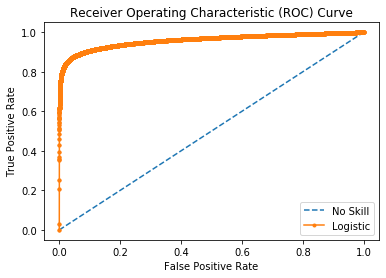

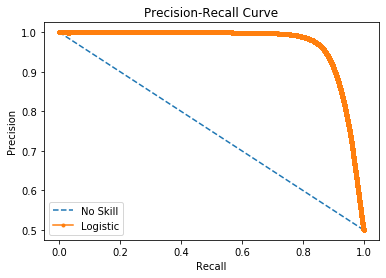

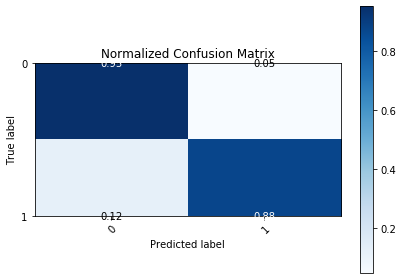

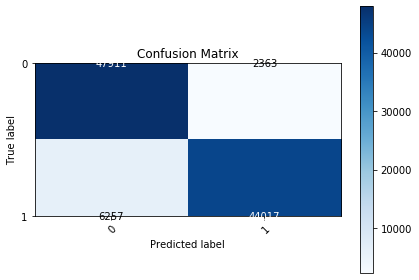

In [4]:
exclusions = []
sig, notsig, X, model, ref2, ref3, ref4, results, summary, interactions, lr_df = build_model(df, 'Round_Won', 0.25, 0.05, exclusions, 'Model_Summary_3v3_V1')

In [5]:
model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1881: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Round_Won   No. Observations:               100548
Model:                          Logit   Df Residuals:                   100467
Method:                           MLE   Df Model:                           80
Date:                Thu, 04 Mar 2021   Pseudo R-squ.:                  0.6552
Time:                        04:06:26   Log-Likelihood:                -24029.
converged:                       True   LL-Null:                       -69695.
                                        LLR p-value:                     0.000
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                                3.4175        nan        nan        nan         nan         nan
TeamRatioUltimatesAll20                             -0.1874        nan        nan        nan         nan         nan
EnemyRatioUltimatesAll20                            -0.2668        nan        nan        nan         nan         nan
TeamRatioREX50                                      -0.5932        nan        nan        nan         nan         nan
EnemyRatioREX50                                      0.2920        nan        nan        nan         nan         nan
NetHealthShards                                      0.0719        nan        nan        nan         nan         nan
NetEnergyShards                                      0.1119        nan        nan        nan         nan         nan
NetOrbs                                              0.7159        nan        nan        nan         nan         nan
First_Orb                                           -0.7808        nan        nan        nan         nan         nan
Ultimates                                            0.9899        nan        nan        nan         nan         nan
Num_R                                                0.6224        nan        nan        nan         nan         nan
Num_EX1                                              0.0336        nan        nan        nan         nan         nan
Num_EX2                                             -0.0569        nan        nan        nan         nan         nan
Protection_Received                                  0.0181        nan        nan        nan         nan         nan
Protection                                           0.0032        nan        nan        nan         nan         nan
Damage_Received                                     -0.0130        nan        nan        nan         nan         nan
Damage                                               0.0075        nan        nan        nan         nan         nan
Control_Received_0.5                                -0.1221        nan        nan        nan         nan         nan
Control_Received_3                                8.003e-08        nan        nan        nan         nan         nan
Control_2                                        -9.262e-06        nan        nan        nan         nan         nan
Control_0.5                                          0.1172        nan        nan        nan         nan         nan
ScorePerSecond_1                                    -0.3817        nan        nan        nan         nan         nan
ScorePerSecond_2                                     0.0288        nan        nan        nan         nan         nan
TeamRatioUltimatesAll20_EnemyRatioUltimatesAll20     0.1673        nan        nan        nan         nan         nan
TeamRatioUltimatesAll20_NetHealthShards             -0.0049        nan        nan 

Download the Model_Summary_3v3_V1.xlsx file for the model summary results for each step in the modeling process.

The model above was built with some team/Net related metrics that includes the energy usage and Net resource gain such as health shards and mid orb. Otherwise, the other metrics is what each individual player scored in that round.

Recall that RatioUltimatesAll represents total number of ultimate usages per team divided by all instances of energy usage (R, EX1, EX2, Ultimates). RatioUltimatesAll20 represents if this ratio is 0.2 or greater.

RatioREX represents the total number of R usage divided by total number of R usage plus EX usage. So, RatioREX50 represents if this ratio is 0.5 or greater.

Since TeamRatioUltimatesAll20 is negative, this tells us that if the team uses ultimates 20% or more out of all energy uses, the odds of winning the round reduces by 1 - exp(-0.1643) = 17% holding all the other variables constant. Similarly, if the ratio of R usage divided by total R and total EX aka TeamRatioREX50 is greater than 0.50 percent, the odds of winning the round reduces by 1 - exp(-0.5932) = 45% holding all the other variables constant.

This would be the case if there were no significant interactions involving these variables, so determining the exact effect of these is not straight forward. All the interactions involving these variables are viable because everything in a game theoretically can interact with each other. The ones found in the model are some of the more statistically significant ones out of the subset of predictors fed into the model.

Note how the First_Orb metric is negative and that makes no sense at all. This is likely due to some interaction terms involving First_Orb and how some of the information may also be contained in NetOrbs. For an example if a round ends within only 1 orb take, NetOrbs remains at 1, the first orb.

The fact that the Pseudo R squared value is only 65.52% tells us that only 65.52% of the variation seen in Round_Won is explained by the predictors of the model. This makes sense because we don't have information about the score of the enemy or respective allies. The pseudo R squared value is the biggest takeaway from this current model without that data.

In [3]:
########################
###3v3 Data version 2###
########################


df = pd.read_csv('Modeling_Data_3v3_V2.csv')
df = df.dropna().reset_index(drop = True)

for col in ['TeamRatioUltimatesAll20', 'EnemyRatioUltimatesAll20', 'TeamRatioREX50',
            'EnemyRatioREX50', 'First_Orb']:
    df[col] = df[col].astype(str)

df['First_Orb'] = df['First_Orb'].str[:-2]

df3 = df.copy()

Step 1
Step 2, 3
Step 4
Step 5
no transformation
no transformation
no transformation
first order var
no transformation
no transformation
no transformation
no transformation
no transformation
second order var
first order var
first order var
first order var
first order var
first order var
first order var
no transformation
no transformation
no transformation
no transformation
second order var
second order var
first order var
second order var
Step 6


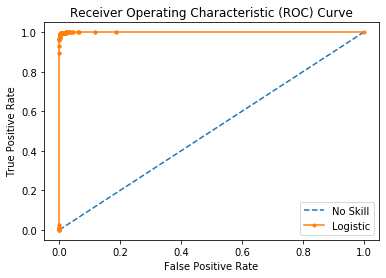

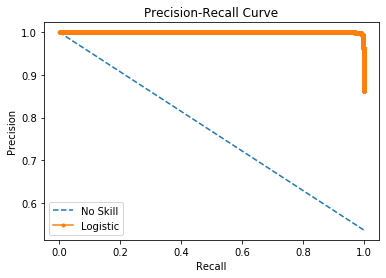

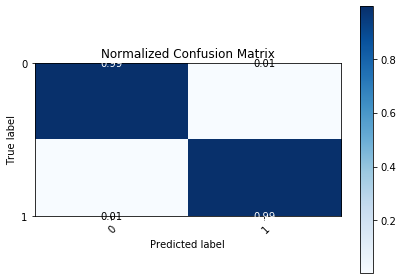

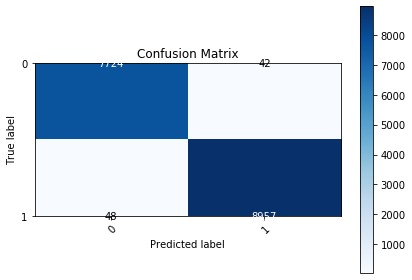

In [5]:
exclusions = []
sig, notsig, X, model, ref2, ref3, ref4, results, summary, interactions, lr_df = build_model(df, 'Round_Won', 0.25, 0.05, exclusions, 'Model_Summary_3v3_V2')

In [6]:
model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1881: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Round_Won   No. Observations:                16771
Model:                          Logit   Df Residuals:                    16703
Method:                           MLE   Df Model:                           67
Date:                Fri, 05 Mar 2021   Pseudo R-squ.:                  0.9769
Time:                        07:04:40   Log-Likelihood:                -267.73
converged:                       True   LL-Null:                       -11579.
                                        LLR p-value:                     0.000
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -0.2213        nan        nan        nan         nan         nan
EnemyRatioREX50                                  -0.0663        nan        nan        nan         nan         nan
NetHealthShards                                   0.3394        nan        nan        nan         nan         nan
NetOrbs                                           1.0876        nan        nan        nan         nan         nan
TeamNetEX                                         0.0395        nan        nan        nan         nan         nan
NetDamage3                                        0.0010        nan        nan        nan         nan         nan
NetProtection1                                    0.0222        nan        nan        nan         nan         nan
NetProtection2                                    0.0216        nan        nan        nan         nan         nan
NetProtection3                                    0.0224        nan        nan        nan         nan         nan
NetProtectionReceived1                            0.0118        nan        nan        nan         nan         nan
NetDamageReceived1                               -0.0375        nan        nan        nan         nan         nan
NetDamageReceived2                               -0.0294        nan        nan        nan         nan         nan
NetDamageReceived3                               -0.0243        nan        nan        nan         nan         nan
NetScorePerSecond1                               -0.3766        nan        nan        nan         nan         nan
TeamNetR_-1                                       0.6122        nan        nan        nan         nan         nan
NetProtectionReceived2_3                      -8.577e-09        nan        nan        nan         nan         nan
NetProtectionReceived2_1                          0.0078        nan        nan        nan         nan         nan
NetProtectionReceived3_-1                         0.3501        nan        nan        nan         nan         nan
NetControl1_2                                 -1.678e-05        nan        nan        nan         nan         nan
NetControl2_3                                  3.146e-07        nan        nan        nan         nan         nan
NetControlReceived1_2                          1.461e-05        nan        nan        nan         nan         nan
NetControlReceived2_-2                            1.1692        nan        nan        nan         nan         nan
NetControlReceived3_-1                           -0.6633        nan        nan        nan         nan         nan
NetScorePerSecond2_2                              0.0032        nan        nan        nan         nan         nan
NetScorePerSecond2_1                             -0.1424        nan        nan        nan         nan         nan
NetScorePerSecond3_1                             

Download the Model_Summary_3v3_V2.xlsx file for the model summary results for each step in the modeling process.

The pseudo R squared value here is tells us that 97.69% of the variation seen in Round_Won is explained by the model which is a great increase from the last model.

Due to the nature of how variables are created, i.e. ordered from highest to lowest, interpreting these metrics in general is difficult. For an example, if the third person scores too high, they would become the 2nd highest scorer on the team, essentially no longer considered the "3" part of the variables. With these interactions between different scorers of the team may be trying to take into account that the higher the weakest link is, the higher the 2nd and highest scores for that team are.

Since the coefficient of NetOrbs is around 3x than NetHealthShards, this shows that the importance of getting one more orb than the enemy team is about the same as taking 3 more health shards than the other team. There is an interaction with NetHealthShards and NetOrbs which is a negative coefficient implying that the effect of both of these resources are reduced a little when you take both likely because there are instances when you "over heal" so the effect isn't as impactful. There are also positive coefficient interactions with NetHealthShards with metrics such as NetDamageReceived3 and NetScorePerSecond1. This implies that NetHealthShards is worth more when the lowest scoring player on each team takes more damage compared to the lowest scoring player on the enemy team. This is not exactly correct, but it does make sense that the people who have taken more damage should pick up the health shards. The positive coefficient with NetScorePerSecond could mean that the more efficient the highest scoring player is with continuing to fight / landing their abilities, the value of their score over time and picking up the health shards give a greater effect on winning the round.

Out of the four energy usage ratio metrics, only EnemyRatioREX50 is significant in the model. The -0.0663 coefficient implies that if the enemy uses R at least twice as much compared to EXs while holding all other variables constant decreases the chance to win the round by 6%. Again, because there are significant interactions with alot of other variables, it's more difficult to measure it's actual effect.

TeamNetEX and TeamNetR are both positive coefficients in the model without any interactions. This means that the more R's and EX's the team uses, the greater chance of victory. This does not tell us much because these metrics don't measure how many times they landed the ability. It is pure based on number of ability usages. But, the fact that these numbers can tilt in any direction means that players for that team happened to either 1. pick up more energy shards, secured more orbs, or landed more abilities than the other team because that's how to get energy. So, the more a team uses energy implies these 3 things which are obviously all important. At least, NetOrbs and landing abilities, since the model does not find NetEnergyShards to be significant.

Whether a team got the first orb is also not significant in this model. As a tournament player, I know this to be false and often times whoever gets first orb sets the tone for the rest of the round, winning in most cases. This may be because tournament games are played at the highest level and teams have voice communication which can properly utilize the advantage the first orb provides. But since this 3v3 data includes only solo queue, casual 3v3, and ranked 3v3 games, this tells us that whoever gets first orb doesn't have much of an impact on round wins overall.

NetDamage1 and NetDamage2 were not found to be statistically significant in the model but NetDamage3 was. This implies that the difference between the weakest link on each team is what can help determine the outcome of a round in 3v3. Holding all other variables constant, 1 unit increase in NetDamage3 will increase the probability of winning a round by exp(0.001)-1 = 0.1%. Now, practically speaking when one player scores higher than someone by 1, that doesn't mean much, so let's use a bigger number difference. Say, a difference of 200. Now, it says that every unit increase of 200 of NetDamage3 means that the chances of increasing round wins is exp(0.001x200)-1 = 22%. NetDamage3 has an interaction with NetDamageReceived2 which is a little strange in terms of how to interpret it within the context of a game, but the size of this coefficient is fairly low.

The coefficients for all three NetDamageReceived metrics are all significant and negative implying that the less damage a team takes compared to the enemy counter part, the greater chances of winning the round. The effect of these coefficients are also much larger compare dto NetDamage3 for an example showing that the difference in DamageTaken between members of the two teams is one of the more important metrics in determing round victories. There are many interactions between NetDamageReceived1 and NetDamageReceived2 with the ScorePerSecond metrics which is not easy to interpret. This goes back to how the rank ordered metrics are difficult to analyze in general because if one person scores too high, they automatically become the 2nd highest scorer etc. We can still make sense of the general size of the coefficients as far as importance because the size of the interactions are generally low. NetDamageReceived1 has the highest effect, NetDamageReceived2 has the second highest, and NetDamageReceived 3 is the lowest, but still significantly higher than NetDamage3. 

THe coefficients for NetProtection related metrics are all significant and positive with effect sizes a little smaller than NetDamageReceived. This is somewhat related to DamageReceived because it has to do with utilizing defensive abilities such as value of shields and heals. Basically, minimizing damage taken while doing damage to the enemy is very important. Surprisingly, differences in ProtectionReceived don't have that much of an impact in comparison.

Higher NetScorePerSecond values in theory means that you're landing abilities at a higher rate and should be associated with winning the round, but as we've seen in the analysis involving strict match making vs not strict matchmaking differences in NetScorePerSecond shows that matches that are closer have greater differences in these values. Because of the presence of so many interaction terms involving ScorePerSecond, it is unclear if higher values of these are associated with winning the round. But, I can tell you that those interactions are definitely valid and it really depends on the situation. I.e. doing a lot of damage while taking a lot of damage and dying is not good but will result in higher score per second. This really goes to show that differences in NetProtection and NetDamageReceived are much more important and clear cut.

In [10]:
########################
###2v2 Data version 1###
########################


df = pd.read_csv('Modeling_Data_2v2_V1.csv')
df = df.dropna().reset_index(drop = True)

for col in ['TeamRatioUltimatesAll20', 'EnemyRatioUltimatesAll20', 'TeamRatioREX50',
            'EnemyRatioREX50', 'First_Orb']:
    df[col] = df[col].astype(str)

df['First_Orb'] = df['First_Orb'].str[:-2]

df3 = df.copy()

Step 1
Step 2, 3
Step 4
Step 5
no transformation
no transformation
second order var
no transformation
second order var
second order var
second order var
second order var
no transformation
no transformation
no transformation
no transformation
no transformation
second order var
Step 6


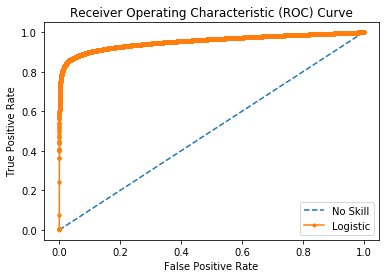

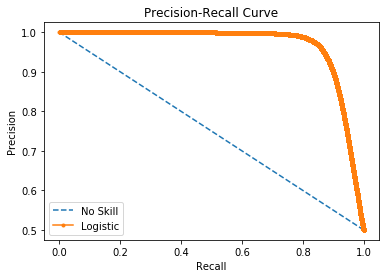

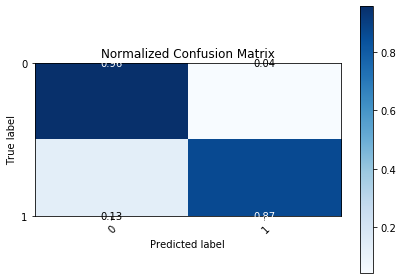

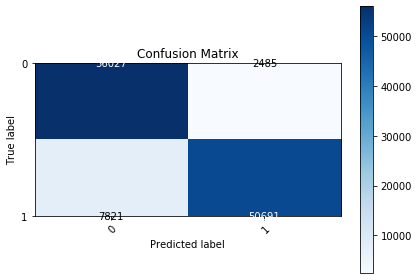

In [11]:
exclusions = []
sig, notsig, X, model, ref2, ref3, ref4, results, summary, interactions, lr_df = build_model(df, 'Round_Won', 0.25, 0.05, exclusions, 'Model_Summary_2v2_V1')

In [12]:
model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1881: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Round_Won   No. Observations:               117024
Model:                          Logit   Df Residuals:                   116940
Method:                           MLE   Df Model:                           83
Date:                Thu, 04 Mar 2021   Pseudo R-squ.:                  0.6428
Time:                        23:28:37   Log-Likelihood:                -28975.
converged:                       True   LL-Null:                       -81115.
                                        LLR p-value:                     0.000
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                                4.3406        nan        nan        nan         nan         nan
TeamRatioUltimatesAll20                              1.1954        nan        nan        nan         nan         nan
EnemyRatioUltimatesAll20                            -0.1359        nan        nan        nan         nan         nan
TeamRatioREX50                                      -0.2541        nan        nan        nan         nan         nan
EnemyRatioREX50                                      0.2665        nan        nan        nan         nan         nan
NetHealthShards                                      0.0783        nan        nan        nan         nan         nan
NetOrbs                                              0.9482        nan        nan        nan         nan         nan
First_Orb                                           -0.7132        nan        nan        nan         nan         nan
Num_R                                                0.7540        nan        nan        nan         nan         nan
Protection_Received                                  0.0178        nan        nan        nan         nan         nan
Protection                                           0.0094        nan        nan        nan         nan         nan
Damage_Received                                     -0.0218        nan        nan        nan         nan         nan
Damage                                               0.0080        nan        nan        nan         nan         nan
Ping                                               4.96e-10        nan        nan        nan         nan         nan
Ultimates_2                                          0.3970        nan        nan        nan         nan         nan
Ultimates_3                                         -0.0338        nan        nan        nan         nan         nan
Num_EX1_0.5                                          1.2289        nan        nan        nan         nan         nan
Num_EX1_1                                            0.0192        nan        nan        nan         nan         nan
Num_EX2_3                                            0.0064        nan        nan        nan         nan         nan
Num_EX2_2                                            0.0141        nan        nan        nan         nan         nan
Control_Received_2                                3.602e-05        nan        nan        nan         nan         nan
Control_Received_1                                  -0.0133        nan        nan        nan         nan         nan
Control_0.5                                          0.2817        nan        nan        nan         nan         nan
Control_1                                           -0.0156        nan        nan        nan         nan         nan
ScorePerSecond_1                                    -0.8760        nan        nan 

Download the Model_Summary_2v2_V1.xlsx file for the model summary results for each step in the modeling process.

In the 3v3 version of the data 65.52% of the variation seen in Round_Won was explained by the model and in this version only 64.28% of the variation in Round_Won is explained by the model. The variables found significant in this version of the data is different than the 3v3 version, but because the same set of data was fed through both models with the same methodology, it can be concluded that indidivudal performance has less of an effect in 2v2 than 3v3.

This is a little counter intuitive because I've personally felt it was always easier to carry games in 2v2 than 3v3 back when solo queue was 2v2 instead of 3v3. The data isn't perfect since the 2v2 games in the dataset counts only casual 2v2 and ranked 2v2. Though, for 3v3 the same issue arises because it's solo queue + casual 3v3 + ranked 3v3 games.

In [8]:
########################
###2v2 Data version 2###
########################


df = pd.read_csv('Modeling_Data_2v2_V2.csv')
df = df.dropna().reset_index(drop = True)

for col in ['TeamRatioUltimatesAll20', 'EnemyRatioUltimatesAll20', 'TeamRatioREX50',
            'EnemyRatioREX50', 'First_Orb']:
    df[col] = df[col].astype(str)

df['First_Orb'] = df['First_Orb'].str[:-2]

df3 = df.copy()

Step 1
Step 2, 3
Step 4
Step 5
no transformation
no transformation
no transformation
no transformation
no transformation
first order var
no transformation
no transformation
no transformation
second order var
first order var
second order var
first order var
first order var
no transformation
no transformation
no transformation
no transformation
first order var
Step 6


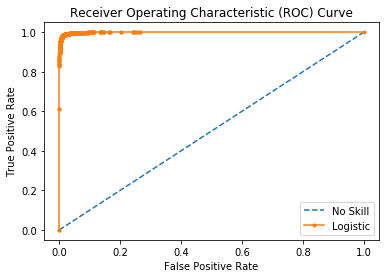

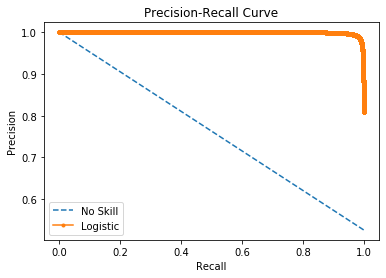

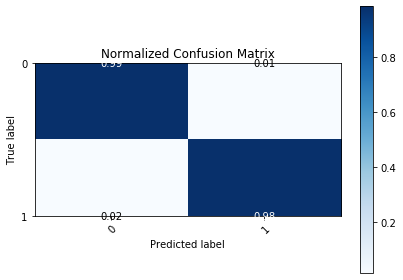

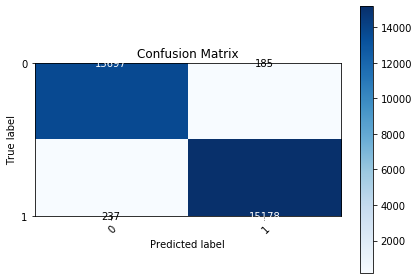

In [9]:
exclusions = []
sig, notsig, X, model, ref2, ref3, ref4, results, summary, interactions, lr_df = build_model(df, 'Round_Won', 0.25, 0.05, exclusions, 'Model_Summary_2v2_V2')

In [10]:
model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1881: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Round_Won   No. Observations:                29297
Model:                          Logit   Df Residuals:                    29237
Method:                           MLE   Df Model:                           59
Date:                Fri, 05 Mar 2021   Pseudo R-squ.:                  0.9420
Time:                        10:34:52   Log-Likelihood:                -1176.5
converged:                       True   LL-Null:                       -20267.
                                        LLR p-value:                     0.000
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                                0.1410        nan        nan        nan         nan         nan
TeamRatioUltimatesAll20                             -0.1246        nan        nan        nan         nan         nan
EnemyRatioUltimatesAll20                             0.1296        nan        nan        nan         nan         nan
TeamRatioREX50                                       0.2907        nan        nan        nan         nan         nan
EnemyRatioREX50                                     -0.0394        nan        nan        nan         nan         nan
NetHealthShards                                      0.2565        nan        nan        nan         nan         nan
NetOrbs                                              0.7740        nan        nan        nan         nan         nan
First_Orb                                           -0.3399        nan        nan        nan         nan         nan
TeamNetUltimates                                    -0.1321        nan        nan        nan         nan         nan
TeamNetEX                                            0.0876        nan        nan        nan         nan         nan
TeamNetR                                             0.0107        nan        nan        nan         nan         nan
NetProtection1                                       0.0213        nan        nan        nan         nan         nan
NetProtection2                                       0.0238        nan        nan        nan         nan         nan
NetProtectionReceived1                               0.0157        nan        nan        nan         nan         nan
NetDamageReceived1                                  -0.0395        nan        nan        nan         nan         nan
NetDamageReceived2                                  -0.0294        nan        nan        nan         nan         nan
NetScorePerSecond1                                  -0.1140        nan        nan        nan         nan         nan
NetScorePerSecond2                                  -0.2633        nan        nan        nan         nan         nan
NetDamage1_3                                      3.072e-10        nan        nan        nan         nan         nan
NetProtectionReceived2_1                             0.0029        nan        nan        nan         nan         nan
NetProtectionReceived2_3                          2.388e-08        nan        nan        nan         nan         nan
NetControl1_3                                    -8.838e-08        nan        nan        nan         nan         nan
NetControlReceived1_3                             3.328e-08        nan        nan        nan         nan         nan
NetControlReceived1_1                               -0.0052        nan        nan        nan         nan         nan
NetControlReceived2_3                            -9.016e-08        nan        nan 

Download the Model_Summary_2v2_V2.xlsx file for the model summary results for each step in the modeling process.

Again, the pseudo R squared value is 94.20% which is lower than the 97.69% value in the 3v3 version of the data.

Looking through the coefficients, it seems the most important effects described in the 3v3 version of the data remains the same in 2v2.

First_Orb is significant here, but it has a negative effect similar to 3v3 version 1 and 2v2 version 1 models due to interaction effects and some correlation with NetOrbs. The negative effect is a bit less here because the overall value is still positive in the event when total orbs taken is 1 and 0.774 - 0.3399 is still > 0. 

The effect of NetHealthShards remains around 3x the value of NetOrbs. NetProtection and NetDamageReceived are still important. One new observation here is that NetProtectionReceived1 has a much larger value here compared to 3v3. This may be due to the fact that most 2v2 comps involve 1 support and 1 DPS character, so the difference in how much the highest scoring players between the two teams has a bigger effect. Despite that overall the model has a lower R squared value, the apparent larger coefficient effects of NetDamageRecieved1 and NetProtectionReceived1 may still imply that one player can impact a game in 2v2 more than 3v3.

The lower R squared value could also mean the effect of the missing effect in the 3v3 version of the data i.e. for the 97.69% pseudo R squared value while very high still is not a perfect 100%. The missing effects there may be amplified for 2v2. The same could be said between 3v3 version 1 and 2v2 version 1 of the data.